<a href="https://colab.research.google.com/github/Gee743/Facial_Emotion_Recognition/blob/main/G21235963_JAFE_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import local_binary_pattern
from google.colab import drive

drive.mount('/content/drive')

# Load Face Detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# LBP Parameters
radius = 1
n_points = 8

# LBP
def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        # Using 'uniform' method
        lbp = local_binary_pattern(img, n_points, radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        lbp_features.append(hist)
    return np.array(lbp_features)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
def load_and_detect_jaffe(folder_path, is_training=True):
    images = []
    labels = []
    # CLAHE is used for local facial features
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    # Gaussian Blur with 3x3 kernel to remove noise without losing too much detail
                    img = cv2.GaussianBlur(img, (3, 3), 0)

                    faces = face_cascade.detectMultiScale(img, 1.1, 5)
                    for (x, y, w, h) in faces:
                        margin_w = int(w * 0.1)
                        margin_h = int(h * 0.1)
                        face_region = img[y+margin_h:y+h-margin_h, x+margin_w:x+w-margin_w]
                        face_region = cv2.resize(face_region, (64, 64))
                        face_region = clahe.apply(face_region)

                        images.append(face_region)
                        labels.append(label)

                        # DATA AUGMENTATION: Help small classes as required
                        if is_training and label in ['fear', 'anger']:
                            images.append(cv2.flip(face_region, 1))
                            labels.append(label)

    return images, labels

In [25]:
# Loading JAFFE Data
train_path = '/content/drive/My Drive/JAFFE/train'
test_path = '/content/drive/My Drive/JAFFE/test'

X_train_raw, y_train = load_and_detect_jaffe(train_path, is_training=True)
X_test_raw, y_test = load_and_detect_jaffe(test_path, is_training=False)

# Extracting Features
X_train = extract_lbp_features(X_train_raw)
X_test = extract_lbp_features(X_test_raw)

# Create Pipeline
svm_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1000, gamma=0.001, class_weight='balanced')
)

svm_model.fit(X_train, y_train)
print("JAFFE Model Training Complete.")

JAFFE Model Training Complete.


In [38]:
y_pred = svm_model.predict(X_test)
print(f"JAFFE Total Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#Visual Prediction
def predict_emotion(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (64, 64))

        face = cv2.bilateralFilter(face, 9, 75, 75)
        features = extract_lbp_features([face])
        prediction = svm_model.predict(features)[0]

        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, str(prediction), (x + 5, y + 35), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


JAFFE Total Accuracy: 21.82%

Classification Report:
               precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         9
        Fear       0.20      0.50      0.29        10
       Happy       0.50      0.22      0.31         9
     Neutral       0.00      0.00      0.00         9
         Sad       0.50      0.11      0.18         9
    Surprise       0.29      0.44      0.35         9

    accuracy                           0.22        55
   macro avg       0.25      0.21      0.19        55
weighted avg       0.25      0.22      0.19        55



In [75]:
from sklearn.model_selection import GridSearchCV
# Hyper parameter tuning
param_grid = {
    'svc__C': [1, 100, 500, 1000],
    'svc__gamma': ['scale', 'auto', 0.1, 0.01],
    'svc__kernel': ['rbf', 'poly']
}

grid_emergency = GridSearchCV(svm_model, param_grid, refit=True, verbose=1, cv=5)
grid_emergency.fit(X_train, y_train)

print(f"New Best Parameters: {grid_emergency.best_params_}")
print(f"Updated Accuracy: {grid_emergency.best_score_ * 100:.2f}%")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
New Best Parameters: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Updated Accuracy: 29.66%


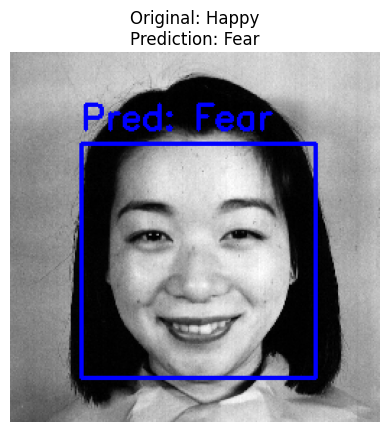

In [37]:
def predict_emotion(image_path, original_label):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (64, 64))
        face = cv2.GaussianBlur(face, (3, 3), 0)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        face = clahe.apply(face)

        features = extract_lbp_features([face])
        prediction = svm_model.predict(features)[0]

        #Draw the square
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Add Prediction label
        cv2.putText(img, f"Pred: {prediction}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    # Set the title to Original vs Prediction
    plt.title(f"Original: {original_label}\nPrediction: {prediction}")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
# Test
predict_emotion('/content/drive/My Drive/JAFFE/test/Happy/YM.HA3.54.tiff', 'Happy')

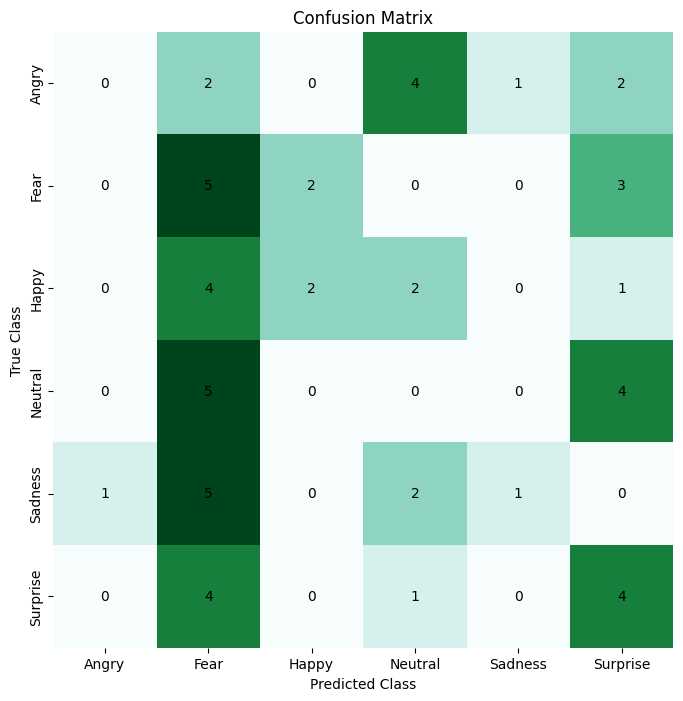

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score


class_names = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]

# Computing confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculating percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix
plt.figure(figsize=(8, 8))
ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn", xticklabels=class_names, yticklabels=class_names, cbar=False)

#Annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}", ha="center", va="center", color="black", fontsize=10)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()